In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('BikeSharingAssignment.csv')

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


The Values of the dataset look clean.. not much of a preprocessing is required, since all data is converted to numerical values. Some preproecessing is required to deal with the datatime values, and some one hot encoding is required for the categorical values.

In [3]:
display(df.info())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


None

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

There are no missing values in the dataset.

All the features' datatypes are correctly assigned automatically by pandas.

This is becoming to look too easy, let's explore the dataset to see if we can find some interesting patterns in the data.

I will develop the pipeline to preprocess the data **AFTER** the EDA, including one hot encoding for the categorical values, and the datetime values. Since this is the best practice.

# Exploratory Data Analysis

## Target Variable EDA

In [4]:
df[['count','registered','casual']].describe()

,count,registered,casual
count,10886.000000,10886.000000,10886.000000
mean,191.574132,155.552177,36.021955
std,181.144454,151.039033,49.960477
min,1.000000,0.000000,0.000000
25%,42.000000,36.000000,4.000000
50%,145.000000,118.000000,17.000000
75%,284.000000,222.000000,49.000000
max,977.000000,886.000000,367.000000


The values cover a really wide range (from 1 to 977), we'll need to see if the extreme values might be outliers.

d:\AI\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


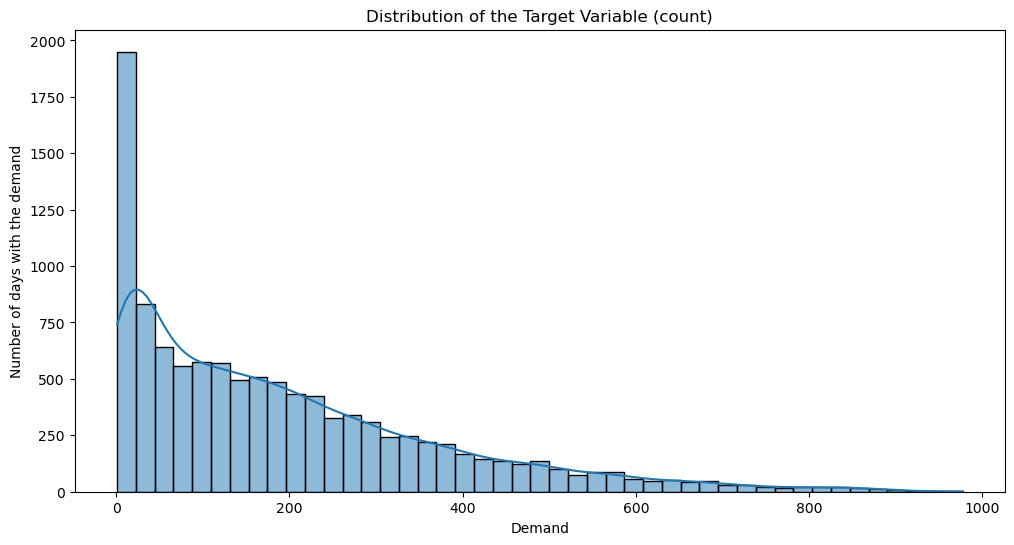

In [5]:
# Plotting the distribution of the target variable(s)

plt.figure(figsize=(12, 6))
sns.histplot(df['count'], kde=True)
plt.title('Distribution of the Target Variable (count)')
plt.xlabel('Demand')
plt.ylabel('Number of days with the demand')
plt.show()

Interesting, the target variable has a very long tail and is really skwed to the right.

I will test for outliers using IQR method, them scale it using Log transformation, then plot it and see what happens.

In [6]:
# Check for outliers mathematically in the target variable(s)

Q1 = df['count'].quantile(0.25)
Q3 = df['count'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['count'] < (Q1 - 1.5 * IQR)) | (df['count'] > (Q3 + 1.5 * IQR))]
outliers

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
6611,2012-03-12 18:00:00,1,0,1,2,24.60,31.060,43,12.9980,89,623,712
6634,2012-03-13 17:00:00,1,0,1,1,28.70,31.820,37,7.0015,62,614,676
6635,2012-03-13 18:00:00,1,0,1,1,28.70,31.820,34,19.9995,96,638,734
6649,2012-03-14 08:00:00,1,0,1,1,18.04,21.970,82,0.0000,34,628,662
6658,2012-03-14 17:00:00,1,0,1,1,28.70,31.820,28,6.0032,140,642,782
...,...,...,...,...,...,...,...,...,...,...,...,...
10678,2012-12-11 08:00:00,4,0,1,2,13.94,15.150,61,19.9995,16,708,724
10702,2012-12-12 08:00:00,4,0,1,2,10.66,12.880,65,11.0014,18,670,688
10726,2012-12-13 08:00:00,4,0,1,1,9.84,11.365,60,12.9980,24,655,679
10846,2012-12-18 08:00:00,4,0,1,1,15.58,19.695,94,0.0000,10,652,662


In [7]:
outliers.shape[0]/df.shape[0]

0.0275583318023149

IQR suggests that about %2.7 of the data is an outlier, before we remove them, let's see if they are really outliers or not. They can be meaningful data points, such as high spikes in demand on holidays, or special events.

In [8]:
# Mathematically check if the target variable is different on holidays and non-holidays

num_holidays_outliers = outliers[outliers['holiday'] == 1]['count'].mean()
num_non_holidays_outliers = outliers[outliers['holiday'] == 0]['count'].mean()

print('The number of outliers on a holiday:', num_holidays_outliers)
print('The number of outliers on a non-holiday:', num_non_holidays_outliers)
print('\n ----------------------------- \n')

# Mathematically check if the target variable is different on weekdays and weekends

num_weekdays_outliers = outliers[outliers['workingday'] == 1]['count'].mean()
num_weekends_outliers = outliers[outliers['workingday'] == 0]['count'].mean()

print('The number of outliers on a weekday:', num_weekdays_outliers)
print('The number of outliers on a weekend:', num_weekends_outliers)
print('\n ----------------------------- \n')


# Mathematically check if the target variable is different in different seasons

spring_outliers = outliers[outliers['season'] == 1]['count'].mean()
summer_outliers = outliers[outliers['season'] == 2]['count'].mean()
fall_outliers = outliers[outliers['season'] == 3]['count'].mean()
winter_outliers = outliers[outliers['season'] == 4]['count'].mean()

print('The number of outliers in spring:', spring_outliers)
print('The number of outliers in summer:', summer_outliers)
print('The number of outliers in fall:', fall_outliers)
print('The number of outliers in winter:', winter_outliers)
print('\n ----------------------------- \n')

# Mathematically check if the target variables is different in different weather conditions

clear_outliers = outliers[outliers['weather'] == 1]['count'].mean()
mist_outliers = outliers[outliers['weather'] == 2]['count'].mean()
light_rain_outliers = outliers[outliers['weather'] == 3]['count'].mean()
heavy_rain_outliers = outliers[outliers['weather'] == 4]['count'].mean()

The number of outliers on a holiday: 694.0
The number of outliers on a non-holiday: 751.5

 ----------------------------- 

The number of outliers on a weekday: 763.6175298804781
The number of outliers on a weekend: 687.0816326530612

 ----------------------------- 

The number of outliers in spring: 708.4375
The number of outliers in summer: 732.1111111111111
The number of outliers in fall: 770.5862068965517
The number of outliers in winter: 755.5507246376811

 ----------------------------- 



I will develop the model with and without the outliers, and see which one performs better.

***Later***

For now we'll keep it as it is.

d:\AI\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


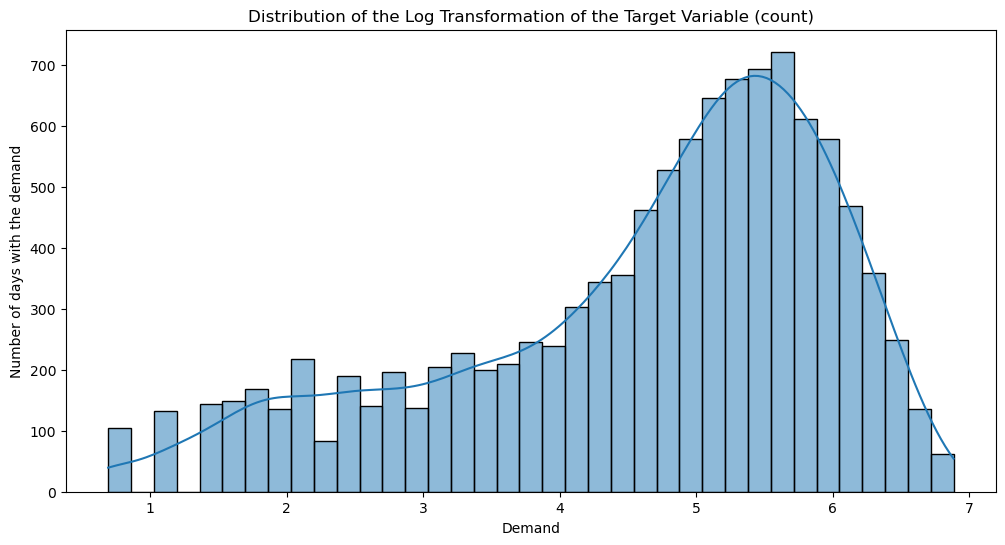

In [9]:
# Visualize the log transformation of the target variable

plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df['count']), kde=True)
plt.title('Distribution of the Log Transformation of the Target Variable (count)')
plt.xlabel('Demand')
plt.ylabel('Number of days with the demand')
plt.show()

It looks slightly better after the log transformation

## Features EDA

Text(0, 0.5, 'Demand')

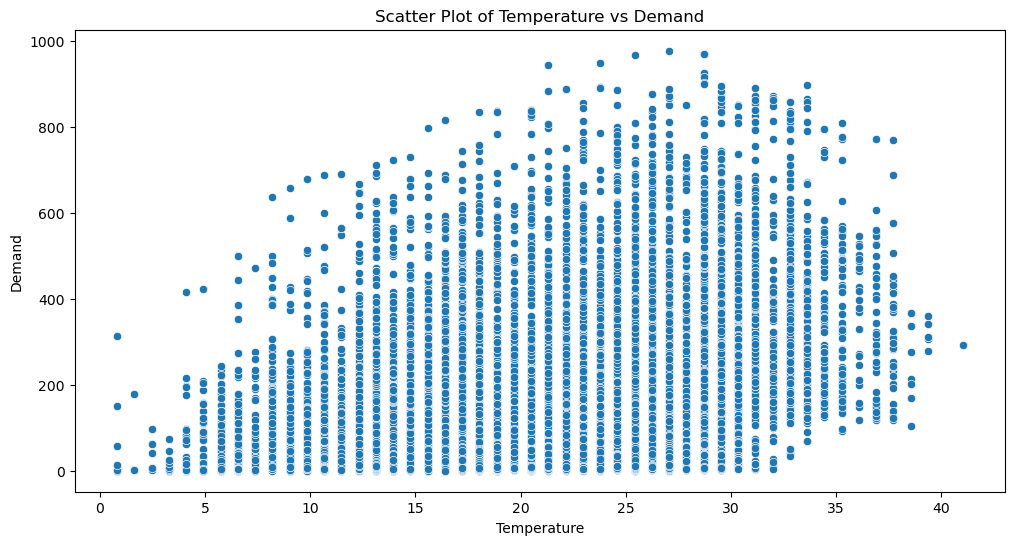

In [10]:
# Plot scatter plots of the target variable(s) with the temp

plt.figure(figsize=(12, 6))
sns.scatterplot(x='temp', y='count', data=df)
plt.title('Scatter Plot of Temperature vs Demand')
plt.xlabel('Temperature')
plt.ylabel('Demand')

The higher the temperature, the slightly higher the demand, which is expected.

Text(0, 0.5, 'Demand')

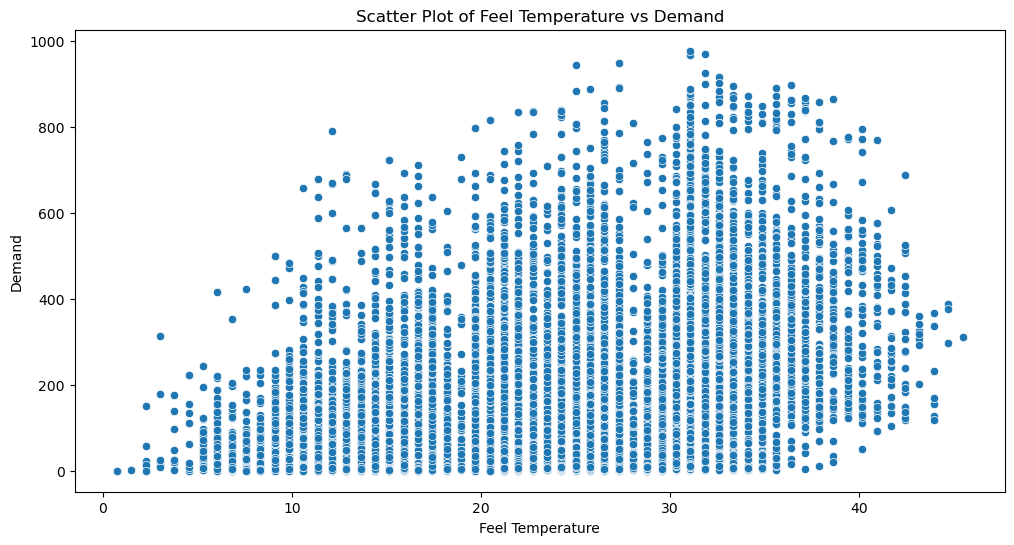

In [11]:
# Plot scatter plots of the target variable(s) with the atemp

plt.figure(figsize=(12, 6))
sns.scatterplot(x='atemp', y='count', data=df)
plt.title('Scatter Plot of Feel Temperature vs Demand')
plt.xlabel('Feel Temperature')
plt.ylabel('Demand')

In [12]:
# See if it's meaningful to keep both temp and atemp in the model

df[['temp', 'atemp']].corr()

,temp,atemp
temp,1.000000,0.984948
atemp,0.984948,1.000000


This is a huge problem, temp and atemp are almost perfectly correlated, the model we're using is Linear Regression, which is extremely sensitive to multicollinearity, we'll need to remove one of them.

Text(0, 0.5, 'Demand')

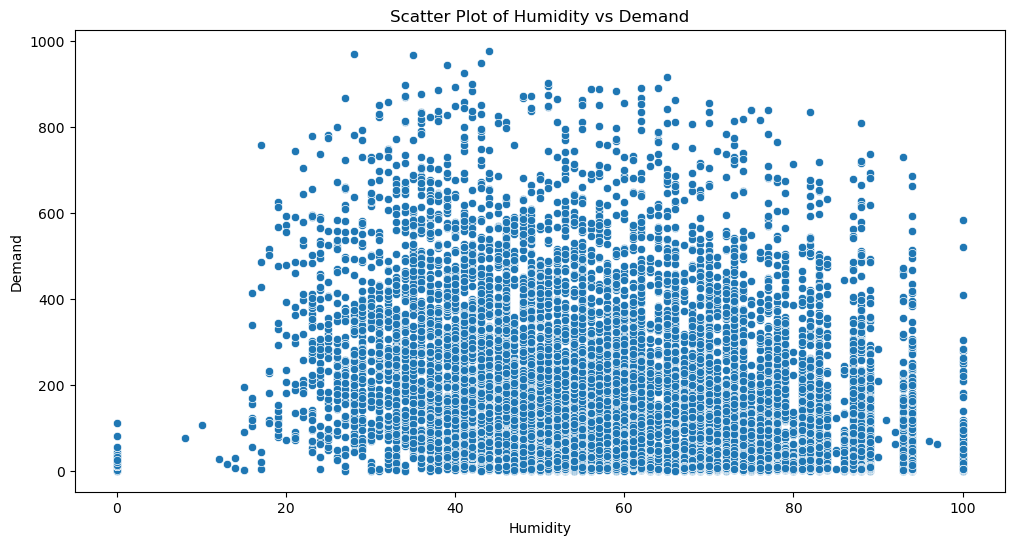

In [13]:
# Plot scatter plots of the target variable(s) with the humidity

plt.figure(figsize=(12, 6))
sns.scatterplot(x='humidity', y='count', data=df)
plt.title('Scatter Plot of Humidity vs Demand')
plt.xlabel('Humidity')
plt.ylabel('Demand')


In [14]:
# Number of days with 0 humidity

num_days_zero_humidity = df[df['humidity'] == 0].shape[0]
num_days_zero_humidity

22

Text(0, 0.5, 'Demand')

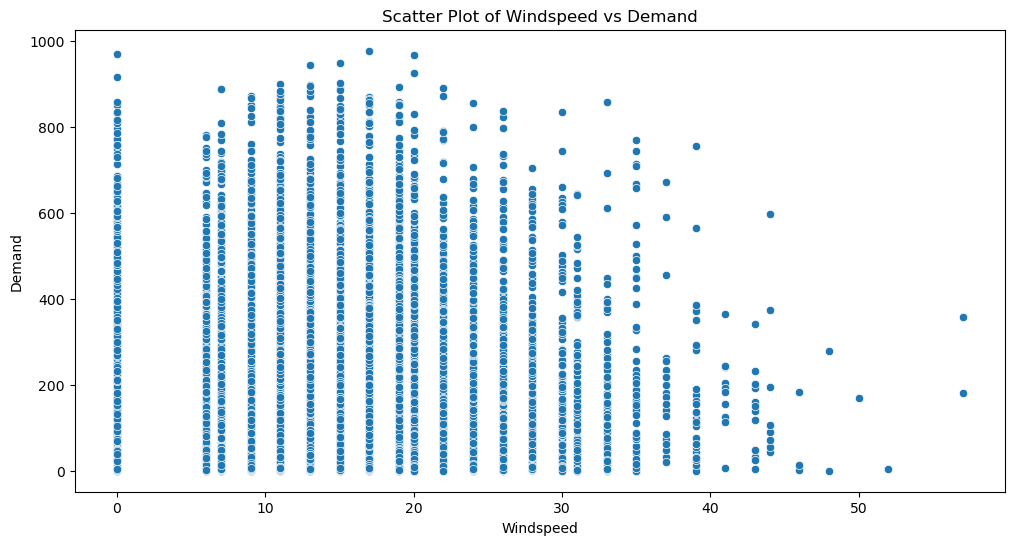

In [15]:
# Plot scatter plots of the target variable(s) with the windspeed

plt.figure(figsize=(12, 6))
sns.scatterplot(x='windspeed', y='count', data=df)
plt.title('Scatter Plot of Windspeed vs Demand')
plt.xlabel('Windspeed')
plt.ylabel('Demand')


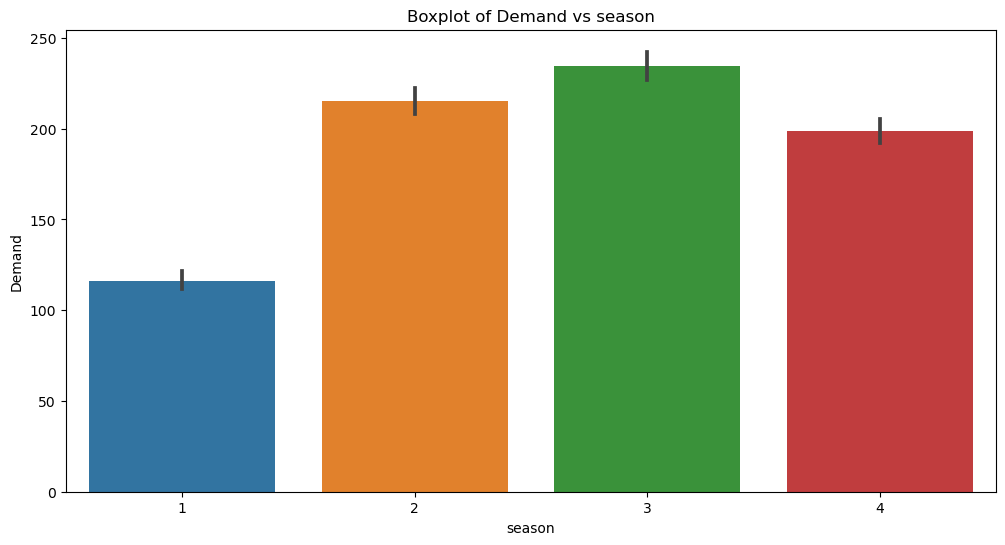

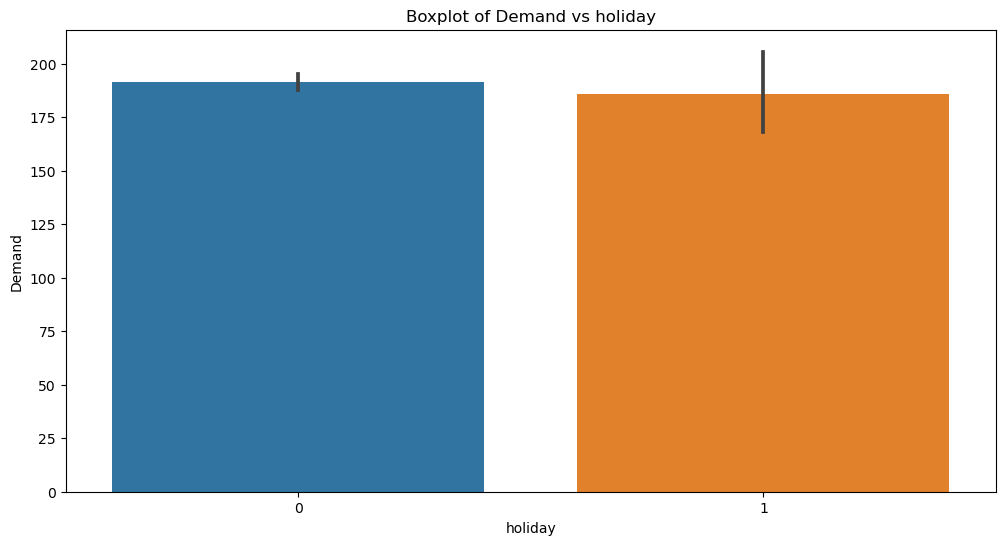

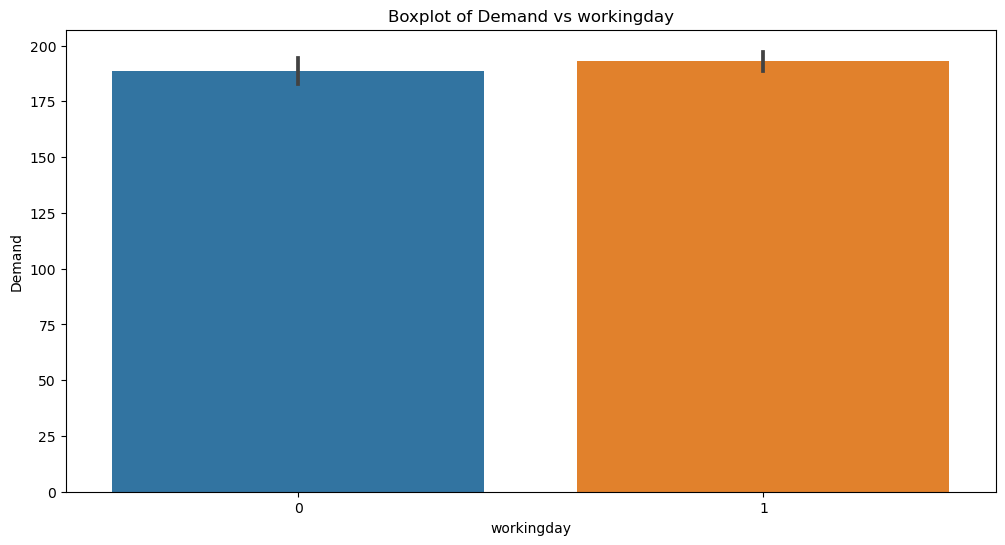

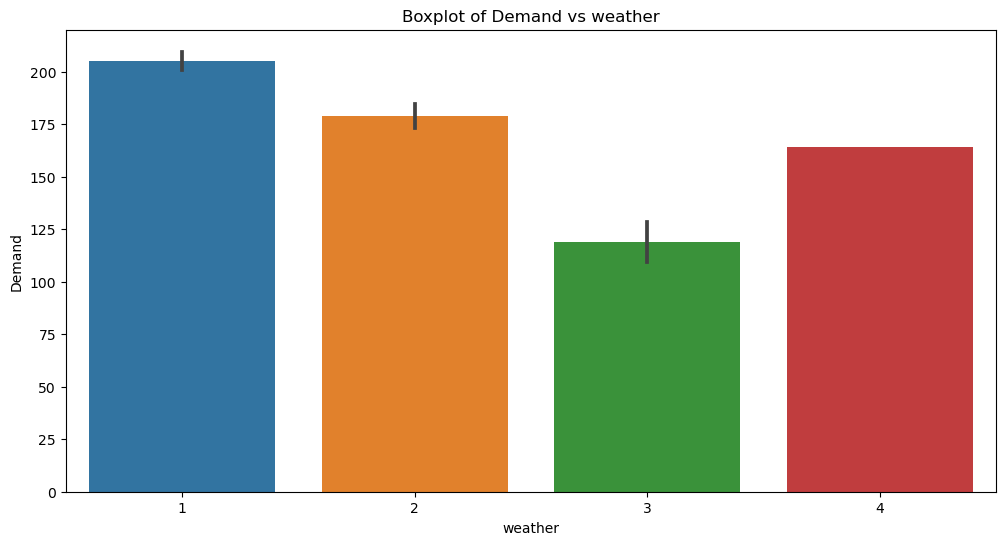

In [16]:
num_features = ['temp', 'atemp', 'humidity', 'windspeed']
cat_features = ['season', 'holiday', 'workingday', 'weather']

# Boxplot of the target variable(s) with the categorical features

for feature in cat_features:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature, y='count', data=df)
    plt.title('Boxplot of Demand vs ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Demand')
    plt.show()
    

1. By Season, 1 = spring, 2 = summer, 3 = fall, 4 = winter
    - Demand is higher in summer and fall, and lower in winter, it is the lowest in spring.

2. By Holiday, 0 = no holiday, 1 = holiday
    - No noticeable difference in demand between holidays and non-holidays.

3. By Workingday, 0 = non-working day, 1 = working day
    - No noticeable difference in demand between working days and non-working days.

4. By Weather,
    1. Clear, Few clouds, Partly cloudy, Partly cloudy (Sunny)
    2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist (Foggy)
    3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (Rainy)
    4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog (Heavy Rain)

    - Demand is the highest in Sunny and Foggy weather, and the lowest in Rainy. It's weird that it's higher in Heavy Rain than in Light Rain.<div style="color: red;">
But who am I to judge 💀?</div>
</div>


Okay I just realized we have not looked at the `datetime` values yet, it seems important, let's look at it.

First I'll ditch the date thing, completely useless, extracting the day isn't useful either, we already have a feature denoting whether it's a working day or not. I'll only extract the hour in a 24-hour format.

I won't apply this to the dataset, it's just for EDA purposes.

In [17]:
# Extract the hour in a 24-hour format from the datetime column

df['hour'] = pd.to_datetime(df['datetime']).dt.hour # This worked :)
df['hour'].head()

0    0
1    1
2    2
3    3
4    4
Name: hour, dtype: int32

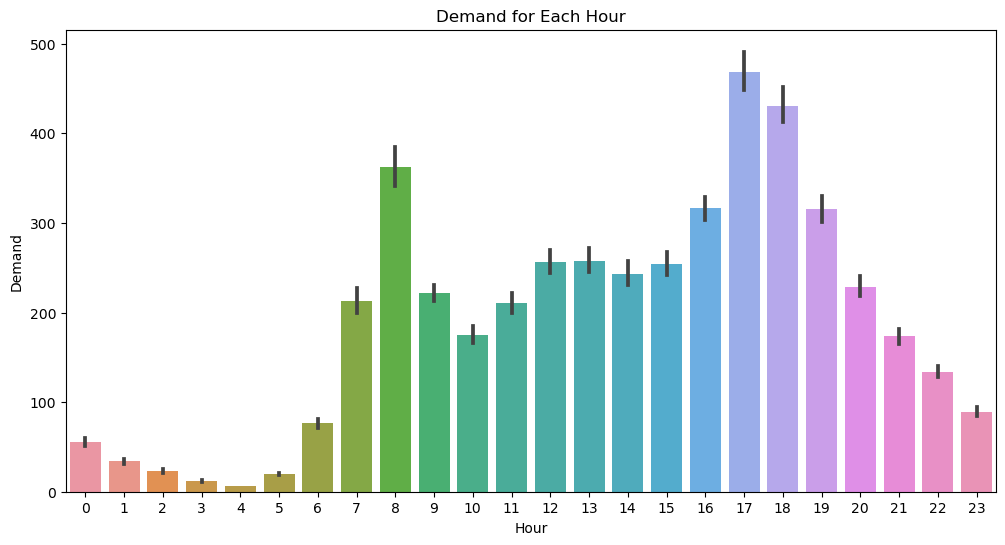

In [18]:
# Plot the demand for each hour

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='count', data=df)
plt.title('Demand for Each Hour')
plt.xlabel('Hour')
plt.ylabel('Demand')
plt.show()

They operate 24/7 ??? Nice

- During morning demand is highest around 8am, probably people going to work.
- Demand is highest in the afternoon around 4pm to 7pm, probably a combination of people going home from work, and people going out for a ride in the sweet afternoon.

## Correlation Analysis 7abibi

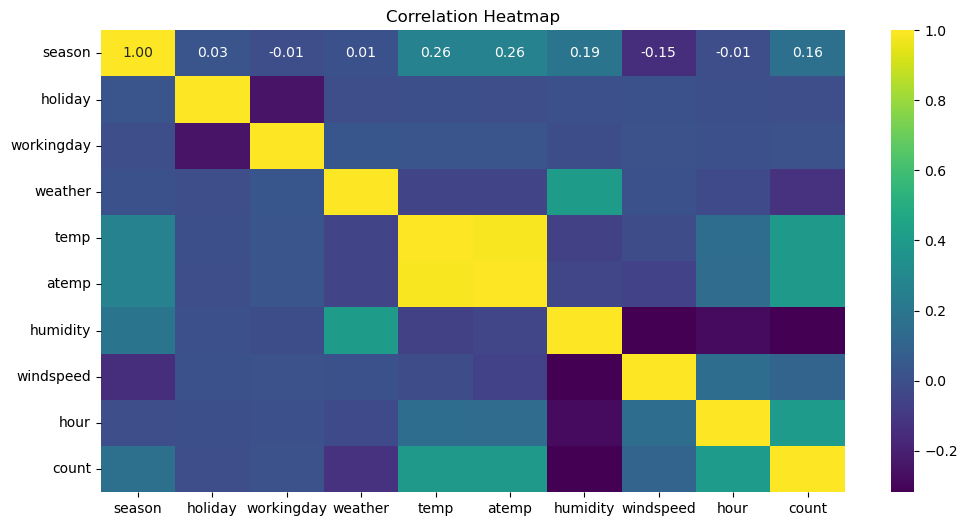

In [19]:
# Create a correlation heatmap to identify features strongly correlated with the target variable.

plt.figure(figsize=(12, 6))
sns.heatmap(df[cat_features + num_features + ['hour','count']].corr(), annot=True, cmap= 'viridis' , fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [20]:
# Calculate correlation

correlation = df[cat_features + num_features + ['hour']].corrwith(df['count'])
print("Correlation with target:\n", correlation.sort_values(ascending=False))

Correlation with target:
 hour          0.400601
temp          0.394454
atemp         0.389784
season        0.163439
windspeed     0.101369
workingday    0.011594
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
dtype: float64


Main Takeaways:
- Again LOL, temp and atemp are almost perfectly correlated, we'll need to remove one of them.
- Demand is slightly linearly correlated with temp, atemp, and hour ***(That would soon only be temp and hour)***.
- Demand is not linearly correlated windspeed, season, holiday, workingday, or weather.
- Demand is slightly negatively correlated with humidity.

I will test other correlation methods before deciding on removing the workingday and holiday features.

I will use Mutual Information

In [21]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information
mi_scores = mutual_info_classif(df[cat_features + num_features + ['hour']], df['count'])
mi_scores = pd.Series(mi_scores, index=df[cat_features + num_features + ['hour']].columns)
print("Mutual Information scores:\n", mi_scores.sort_values(ascending=False))

d:\AI\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\AI\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Mutual Information scores:
 hour          0.582578
weather       0.372662
workingday    0.244787
temp          0.134931
season        0.134275
atemp         0.130464
humidity      0.089285
windspeed     0.029249
holiday       0.004144
dtype: float64


Okay, it seems like only the holiday feature needs to be removed, BUT, there's an important thing to note. 

Since we are using linear regression, we can use Lasso Regression (L1 regularization) which can autmoatically set the coefficients of the non-important features to 0 (or close to zero), so we can keep the holiday feature and let Lasso decide if it's important or not.

# Feature Engineering and Modeling

We've already created an extra feature, `hour`, from the `datetime` feature.
- This feature has proven to be meaningful in the EDA, and it's the MOST correlated feature with the target variable.

And it seems like a good idea to combine wind and tempraure into a single feature, since that could indicate something like how cold it feels.
- This feature can provide additional meaningful description of the weather which is indeed important in predicting the demand.

I will follow Standard Best Practices and develop the pipeline to preprocess the data, including one hot encoding, feature engineering, and scaling.

In [22]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV

np.random.seed(21)


num_features = ['atemp', 'humidity', 'windspeed']
cat_features = ['season', 'holiday', 'workingday', 'weather']

def extract_datetime(X):
    X = X.copy()
    X['hour'] = pd.to_datetime(X['datetime']).dt.hour
    X.drop('datetime', axis=1, inplace=True)
    return X

extract_datetime_transformer = FunctionTransformer(extract_datetime, validate=False)

def add_windchill(X): # and drop temp
    X = X.copy()
    X['windcill'] = X['windspeed'] * X['atemp']
    X.drop('temp', axis=1, inplace=True)
    return X

add_wind_temp_transformer = FunctionTransformer(add_windchill, validate=False)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ]
)

preprocessing_pipeline = Pipeline([
    ('extract_hour', extract_datetime_transformer),
    ('add_windchill', add_wind_temp_transformer),
    ('preprocessor', preprocessor)
])

# Model Definitions
lr = LinearRegression()

# Target Transformation
target_transformer = FunctionTransformer(np.log, inverse_func=np.exp, validate=False)

# Full Pipeline
regressor= TransformedTargetRegressor(
    regressor=lr,
    transformer=target_transformer
)

full_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('regressor', regressor)
])


There is no need for me to create a validation set, since I'm using GridSearchCV with cross-validation autmatically created and handled for us by sklearn.

In [23]:
# Split the data into train,and test sets

from sklearn.model_selection import train_test_split

X = df.drop(columns=['count','registered','casual'])
y = df['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Train set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

Train set shape: (8708, 10) (8708,)
Test set shape: (2178, 10) (2178,)


In [24]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Final Model Training and Evaluation

model = full_pipeline.fit(X_train, y_train)

# Predictions on original scale
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Metrics:')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')

Metrics:
MAE: 112.1736
RMSE: 163.3219
R^2: 0.1070


The Linear Regression Model severly underfit the data.


Residual Statistics:
Mean Residual: 53.7632
Residual Variance: 23794.4698


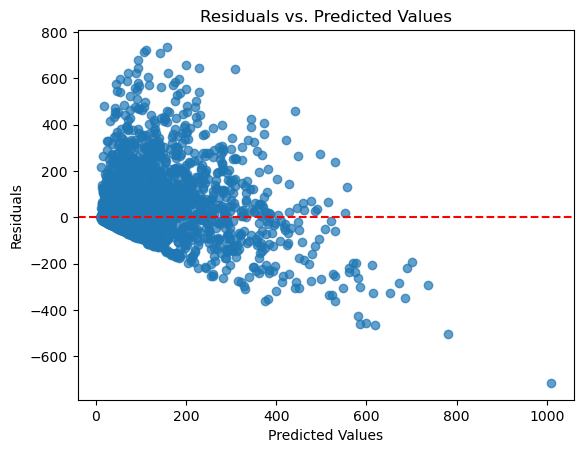

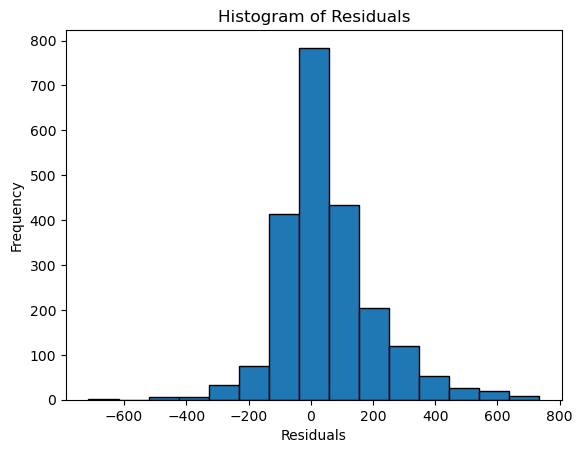

In [25]:
# Predictions
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

print(f'\nResidual Statistics:')
print(f'Mean Residual: {residuals.mean():.4f}')
print(f'Residual Variance: {residuals.var():.4f}')

# Residuals vs. Predicted Values
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

# Histogram of Residuals
plt.hist(residuals, bins=15, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

### Seeing how the model performs with outliers removed

In [26]:
# Testing it without outliers

df = df[(df['count'] > (Q1 - 1.5 * IQR)) & (df['count'] < (Q3 + 1.5 * IQR))]

# Split the data into train,and test sets

from sklearn.model_selection import train_test_split

X = df.drop(columns=['count','registered','casual'])
y = df['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Train set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

Train set shape: (8466, 10) (8466,)
Test set shape: (2117, 10) (2117,)


In [27]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Final Model Training and Evaluation

model = full_pipeline.fit(X_train, y_train)

# Predictions on original scale
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Metrics:')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')

Metrics:
MAE: 102.2901
RMSE: 146.3601
R^2: 0.1277



Residual Statistics:
Mean Residual: 55.8989
Residual Variance: 18305.2551


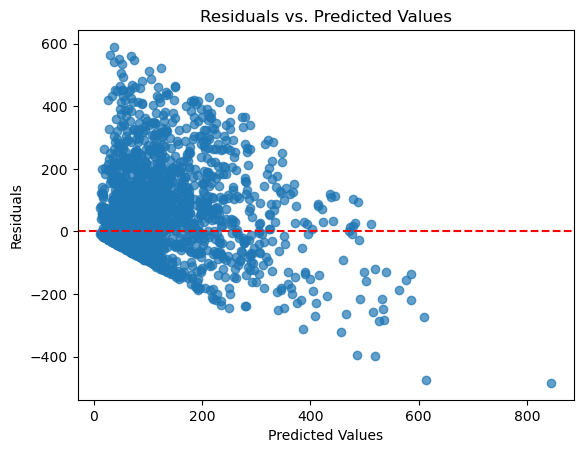

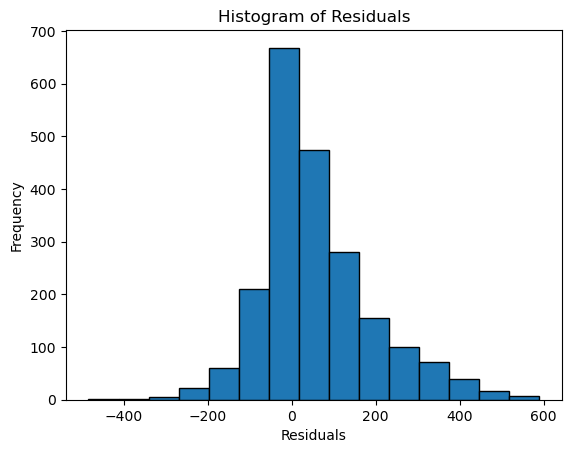

In [28]:
# Predictions
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

print(f'\nResidual Statistics:')
print(f'Mean Residual: {residuals.mean():.4f}')
print(f'Residual Variance: {residuals.var():.4f}')

# Residuals vs. Predicted Values
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

# Histogram of Residuals
plt.hist(residuals, bins=15, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

## Model Without Feature Engineering

In [29]:
num_features = ['temp','atemp', 'humidity', 'windspeed']
cat_features = ['season', 'holiday', 'workingday', 'weather']


# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ]
)

preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

lr = LinearRegression()

# Target Transformation
target_transformer = FunctionTransformer(np.log, inverse_func=np.exp, validate=False)


regressor= TransformedTargetRegressor(
    regressor=lr,
    transformer=target_transformer
)

full_pipeline_no_feature_engineering = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('regressor', regressor)
])


In [30]:
# Split the data into train,and test sets

from sklearn.model_selection import train_test_split

X = df.drop(columns=['count','registered','casual'])
y = df['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Final Model Training and Evaluation

model_no_feature_engineering = full_pipeline_no_feature_engineering.fit(X_train, y_train)

# Predictions on original scale
y_pred = model_no_feature_engineering.predict(X_test)

# Evaluation Metrics on Original Scale
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Metrics:')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')

Metrics:
MAE: 101.1800
RMSE: 144.4703
R^2: 0.1431



Residual Statistics:
Mean Residual: 52.7594
Residual Variance: 18096.6699


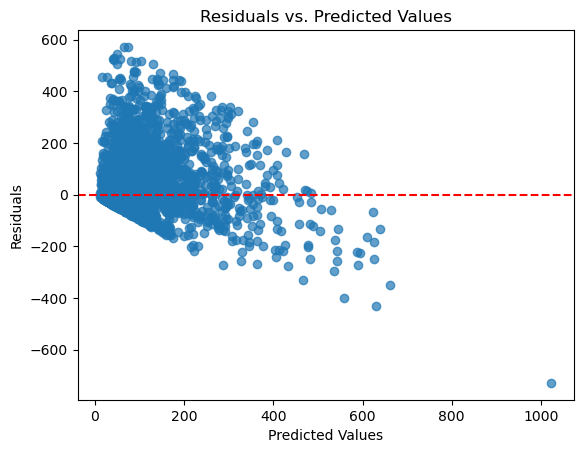

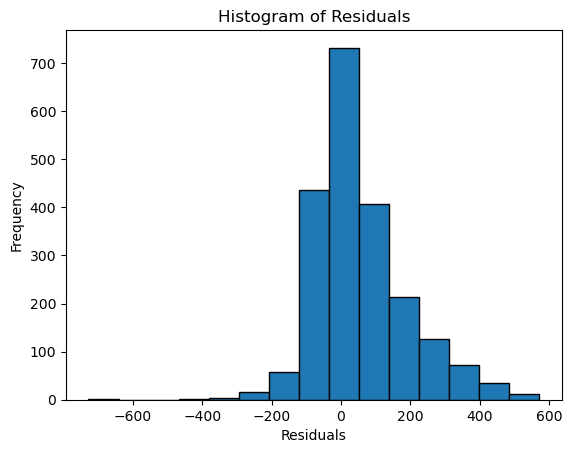

In [32]:
# Predictions
y_pred = model_no_feature_engineering.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

print(f'\nResidual Statistics:')
print(f'Mean Residual: {residuals.mean():.4f}')
print(f'Residual Variance: {residuals.var():.4f}')

# Residuals vs. Predicted Values
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

# Histogram of Residuals
plt.hist(residuals, bins=15, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


# Conclusion

  

### Key Findings from EDA

- The target variable has a very long tail and is really skwed to the right, I decided to apply a `log transformation` to it.
- I investigated the possibility of having outliers in the Target Variable.
- The higher the temperature, the slightly higher the demand.
- `temp` and `atemp` are linearly correlated with each other which can cause problem for models similar to `LinearRegression`
-----------
- Categorical Features:
	1. By Season, 1 = spring, 2 = summer, 3 = fall, 4 = winter
	    - Demand is higher in summer and fall, and lower in winter, it is the lowest in spring.

	2. By Holiday, 0 = no holiday, 1 = holiday
	    - No noticeable difference in demand between holidays and non-holidays.

	3. By Workingday, 0 = non-working day, 1 = working day
	    - No noticeable difference in demand between working days and non-working days.

	4. By Weather
		1. Clear, Few clouds, Partly cloudy, Partly cloudy (Sunny)
		2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist (Foggy)
		3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (Rainy)
		4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog (Heavy Rain)

		    - Demand is the highest in Sunny and Foggy weather, and the lowest in Rainy. It's weird that it's higher in Heavy Rain than in Light Rain.
  
--------

- Hour:
	- During morning demand is highest around 8am, probably people going to work.

	- Demand is highest in the afternoon around 4pm to 7pm, probably a combination of people going home from work, and people going out for a ride in the sweet afternoon.
-----------
- Correlation Analysis:

	- Again, temp and atemp are almost perfectly correlated, we'll need to remove one of them.

	- Demand is slightly linearly correlated with temp, atemp, and hour.

	- Demand is not linearly correlated windspeed, season, holiday, workingday, or weather.

	- Demand is slightly negatively correlated with humidity.
	- ---------------
#### 1. The First Model with some Feature Engineering:

- Metrics:
	* MAE: 112.1736
	* RMSE: 163.3219
	* R^2: 0.1070

- Residual Statistics:
	* Mean Residual: 53.7632
	* Residual Variance: 23794.4698


#### 2. The Second Model without outliers
- Metrics:
	* MAE: 106.6959
	* RMSE: 151.1721
	* R^2: 0.0614
	* 
- Residual Statistics:
	* Mean Residual: 58.8030
	* Residual Variance: 19404.3771
  

#### 3. The Third Model without Feature Engineering

- Metrics:
	* MAE: 112.1916
	* RMSE: 167.5386
	* R^2: 0.1088

- Residual Statistics:
	* Mean Residual: 58.6880
	* Residual Variance: 24636.2219
  
---------------

  Based on the metrics and residual statistics:

1.  **Model 2 without outliers**  performs the best overall:
    
    -   It has the  **lowest MAE (106.6959)**  and  **lowest RMSE (151.1721)**, indicating better prediction accuracy and fewer large errors.
        
    -   It also has the  **lowest residual variance (19404.3771)**, suggesting more consistent predictions.
        
    -   Although its  **R² (0.0614)**  is lower than the other models, the improvement in MAE and RMSE makes it the preferred choice.
        
2.  **Model 1 with feature engineering**  and  **Model 3 without feature engineering**  perform similarly:
    
    -   Both have comparable MAE, RMSE, and R² values, but Model 1 has a slightly lower mean residual (53.7632 vs. 58.6880), indicating less bias.
        
    -   However, neither outperforms Model 2 without outliers.

Train set shape: (8466, 10) (8466,)
Test set shape: (2117, 10) (2117,)
Metrics:
MAE: 100.9216
RMSE: 143.4725
R^2: 0.1396


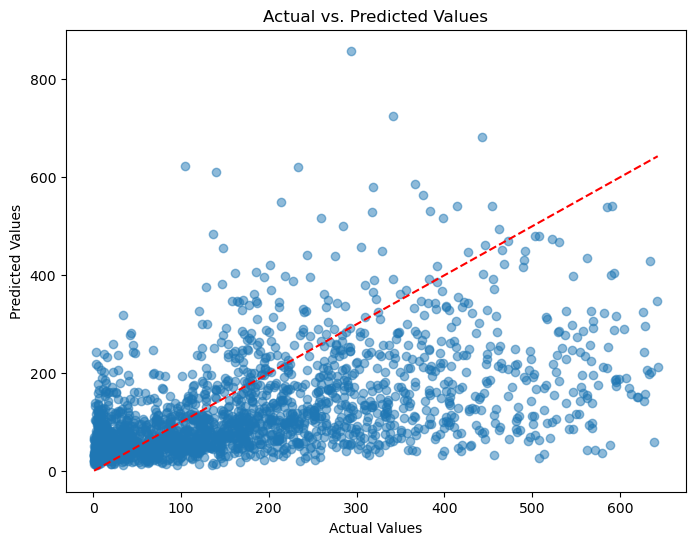

In [33]:
# using the second model...

# Testing it without outliers

df = df[(df['count'] > (Q1 - 1.5 * IQR)) & (df['count'] < (Q3 + 1.5 * IQR))]

# Split the data into train,and test sets

from sklearn.model_selection import train_test_split

X = df.drop(columns=['count','registered','casual'])
y = df['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Train set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Final Model Training and Evaluation

model = full_pipeline.fit(X_train, y_train)

# Predictions on original scale
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Metrics:')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')


# Scatter plot of actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

The model usually underpredicts, this suggests that the model is underfitting the data (it has high bias).